# Part 3: EM implementation

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
def read_data():
    with open('sequence.padded.txt') as handle:
        # I dont think this is the actual sequences we should be using
        # put using as placeholder for now.
        return [s.strip() for s in handle.readlines()]

data = read_data()
data

['ATACCCCTGGCTGGGTCATGGTGACCTGGAGGAAGCGT',
 'CATATATGGCCAGGGTCAGTGTGACCTCCATTTCCCAT',
 'AGCAGCTGGCCTGGGTCACAGTGACCTGACCTCAAACC',
 'AGGCTGTGTACAAGGTCAGAGTGACCTCTAGAAGCTCT',
 'TACTCTAGTTCCAGGTCATGGTGACCTGTGAAAAATCT',
 'AGGACTGTTTCAAGGTCACGGTGACCCTCGTGGGCTGT',
 'GCAGGAAGTTTTGGGTCACGGTGACCTCTAGTTGTTGA',
 'CAAGTGCTTCAAAGGTCATGGTGCCCTGGGGCCGAGAG',
 'ACCAACATGGCAGGGTCAAGTTGACCTCCCTGGCCACT',
 'TCTCTCTCTAGTAGGTCATGGTGACCTGTACACATTAT',
 'TCAGACCACAGAGGGTCAAGGTGACCTGAGAGATCAGT',
 'AGGCAATTCACTAGGTCAGGATGCCCTGGGGCAACAGT',
 'TAGTCCTGAAAAGGGTCATGTTGACCTGATTGTCATGT',
 'ATTAACTCTTCTAGGTCAGTGTGACCTAAACTCATCGG',
 'GGACAATTATTGGGGTCACGGTGACCTGCCTGTTTCAG',
 'GGTCCATAATATAGGTCATGTTGACCTGGGACAACTGG',
 'CTCCAGGAGCAGGGGTCAGGGTGACCTCCAGCTCCTCA',
 'GAGCCCATCTCTGGGTCATGTTGCCCTCTTACAGCACA',
 'TGGGTTAAACCTGGGTCATGTTGACCTAGATACATCTC',
 'GTGACATCCCCAGGGTCAAAGTGCCCTGAGTCTGGAGA',
 'GCCTTCTAGGTCAGCATGACCTGGTCCTCAGAGGGGGG',
 'GGCAATGAATCAAGGTCAGGCTAACCTGGCTTACTGCA',
 'CCTACTAGCCCTGGGTCAACGTGCCCTGTAAGAGCATG',
 'GGCGCAGCC

Create matrix $X_{i,j,p,k}$ using one-hot encoding scheme.

In [3]:
seq_length = len(data[0])
motif_length = 8
number_motifs = seq_length - motif_length + 1
X = np.zeros((len(data), number_motifs, motif_length, 4))

def nuc_to_one_hot(nuc):
    # Convert nucleotide to the index in one hot encoded array
    # that should be hot (==1)
    upper_nuc = nuc.upper()
    mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    return mapping[upper_nuc]

j_p = []
for i in range(len(data)):
    for j in range(number_motifs):
        for p in range(motif_length):
            nuc = data[i][j+p]
            k_hot = nuc_to_one_hot(nuc)
            X[i][j][p][k_hot] = 1.0

Randomly initialize the model parameters.

In [4]:
def init_EM(seq_length, motif_length):
    number_motifs_per_sequence = seq_length - motif_length + 1
    lambda_j = np.random.uniform(0, 1, size=(number_motifs_per_sequence,))
    lambda_j_norm = lambda_j / lambda_j.sum()
    psi_0 = np.random.uniform(0, 1, size=(4, motif_length))
    psi_1 = np.random.uniform(0, 1, size=(4, motif_length))
    psi_0 = (psi_0/psi_0.sum(axis=0)).T
    psi_1 = (psi_1/psi_1.sum(axis=0)).T
    
    return lambda_j_norm, psi_0, psi_1

In [5]:
lambda_j, psi_0, psi_1 = init_EM(seq_length, motif_length)

## E step

![](e.png)

In [6]:
def e_numerator(i, j, X, lambda_j, psi_0, psi_1):
    # i = current sequence
    # j = current j index
    # X = Data
    psi_1_term = X[i][j] * psi_1
    # remove zero terms this is in lieu of having exponent X_{i,j,p,k}
    # whcih would cause 0 encoded values (cold values) to have
    # value of 1 and therefore not contribute to the product
    psi_1_term = psi_1_term[psi_1_term != 0]
    # take product of all remaining terms (these are probibities seeing
    # the bases in the given motif in their given positions given they
    # are in the TFBS)
    psi_1_term = np.log(psi_1_term).sum()
    
    # now need to get product of all other motifs (j' != j) but assuming they are
    # not the TFBS (psi^0). 
    psi_0_term = X[i][np.arange(len(X[i]))!=j] * psi_0
    psi_0_term = psi_0_term.flatten()
    psi_0_term = np.log(psi_0_term[psi_0_term != 0]).sum()
    return np.log(lambda_j[j]) + psi_0_term + psi_1_term  # log of products is sum of logs

In [7]:
def e_step(X, lambda_j, psi_0, psi_1):
    post = []
    for i in range(X.shape[0]):
        post.append([])
        for j in range(X.shape[1]):
            post[i].append(e_numerator(i, j, X, lambda_j, psi_0, psi_1))
        post[i] = np.array(post[i])
        min_value = post[i].min()
        post[i] = np.e ** (post[i] - min_value)
        post[i] = post[i] / post[i].sum()
    
    return np.array(post)

posts = e_step(X, lambda_j, psi_0, psi_1)

Calculate ELBO. What exactly is ELBO here?

In [8]:
def calculate_ELBOOOOO(X, posts, lambda_j, psi_0, psi_1):
    
    def lambda_j_term():
        return (posts * np.log(lambda_j)).sum()
    
    def C_ij_term():
        sum_list = []
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                for p in range(X.shape[2]):
                    for k in range(X.shape[3]):
                        sum_list.append(
                            X[i][j][p][k] * (posts[i][j] * np.log(psi_1[p][k]) + (1 - posts[i][j]) * np.log(psi_0[p][k]))
                        )
        return sum(sum_list)
    
    def entropy():
        return (np.log(posts) * posts).sum()
    
    return lambda_j_term() + C_ij_term() + entropy()        

## M step

Quon says $\boldsymbol{E}[C_{i,j}] = P(C_{i} = j | X_{i}, \theta)$

He also gives what $\boldsymbol{E}[C_{i,j}] = P(C_{i} = j | X_{i}, \theta)$ equals to in the E step (shown in the image below.)

### $\lambda_{j}$

In [9]:
# Make practice posterior to troubleshoot M-step
lambda_j, psi_0, psi_1 = init_EM(seq_length, motif_length)
practice_posterior = []
for i in range(X.shape[0]):
    practice_posterior.append(lambda_j)
practice_posterior = np.array(practice_posterior)

In [10]:
def lambda_j_m_step(E_Cij):
    return E_Cij.sum(axis=0) / E_Cij.shape[0]

In [11]:
lambda_j_m_step(practice_posterior).shape

(31,)

In [12]:
lambda_j.shape

(31,)

### $\psi^{1}_{p, k}$

Product of indicator variables for a given motif (For example the matrix at `X[0][0]`) and the expectation at that motif calculated during the E step. Then take a sum overall all those values and divide by the number of sequences.

In [13]:
def psi_1_m_step(X, E_Cij, psi_1):
    new_psi_1 = np.zeros(psi_1.shape)
    for p in range(psi_1.shape[0]):
        for k in range(psi_1.shape[1]):
            numerator_terms = []
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    numerator_terms.append(X[i][j][p][k] * E_Cij[i][j])
            psi_pk = sum(numerator_terms) / X.shape[0]
            new_psi_1[p][k] = psi_pk
    return new_psi_1
            
            
psi_1_pract = psi_1_m_step(X, posts, psi_1)
psi_1_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

### $\psi^{0}_{p, k}$

Seems pretty much like other $\psi$ but add some subtractions and change the denominator to the number of sequences times the number of possible motifs.

In [14]:
def psi_0_m_step(X, E_Cij, psi_1):
    new_psi_1 = np.zeros(psi_1.shape)
    
    motif_length = X.shape[2]
    seq_length = X.shape[1] * motif_length
    
    for p in range(psi_1.shape[0]):
        for k in range(psi_1.shape[1]):
            numerator_terms = []
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    numerator_terms.append(
                        X[i][j][p][k] * (1 - E_Cij[i][j])
                    )

            psi_pk = sum(numerator_terms) / ((seq_length - motif_length + 1 - 1) * (X.shape[0]))
            new_psi_1[p][k] = psi_pk
            
    return new_psi_1
            
            
psi_1_pract = psi_1_m_step(X, posts, psi_1)
psi_1_pract.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
def m_step(X, E_cij, lambda_j, psi_1, psi_0):
    return lambda_j_m_step(E_cij), psi_1_m_step(X, E_cij, psi_1), psi_0_m_step(X, E_cij, psi_0)

In [16]:
import matplotlib.pyplot as plt

In [19]:
l_0, l_1 = 0, 1e10
l_diff = 1e-3
lambda_j, psi_0, psi_1 = init_EM(seq_length, motif_length)
elbos = []
for i in range(10):
    posteriors = e_step(X, lambda_j, psi_0, psi_1)
    lambda_j, psi_0, psi_1 = m_step(X, posteriors, lambda_j, psi_1, psi_0)
    l_0 = l_1
    l_1 = calculate_ELBOOOOO(X, posteriors, lambda_j, psi_1, psi_0)
    elbos.append(l_0 - l_1)
    print(elbos[i])

10000301334.12107
852.901084727433
-466.1159905414097
282.47789453546284
-361.5951957779471
149.98810088046594
-232.94597376539605
42.189629254862666
-120.4544905773364
-63.32806459243875


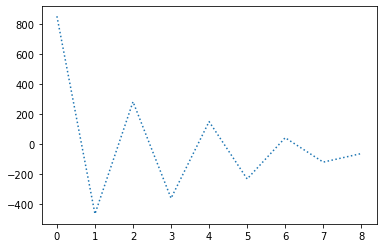

In [22]:
plt.plot(elbos[1:], linestyle = 'dotted')